# Data analysis of cleaned dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import chi2_contingency, mannwhitneyu

In [2]:
Path.cwd()

WindowsPath('c:/Applied Data Science/Projects/MADS-PREMOD03-Portfolio-Code/02_wip/notebooks')

In [3]:
# Confirmation of data cleaned
from pathlib import Path
import pandas as pd

ROOT = Path("..").resolve().parents[0]
DATA_FILE = ROOT / "01_data" / "processed" / "dataset_clean.parquet"

df = pd.read_parquet(DATA_FILE)
df.shape




(30478, 21)

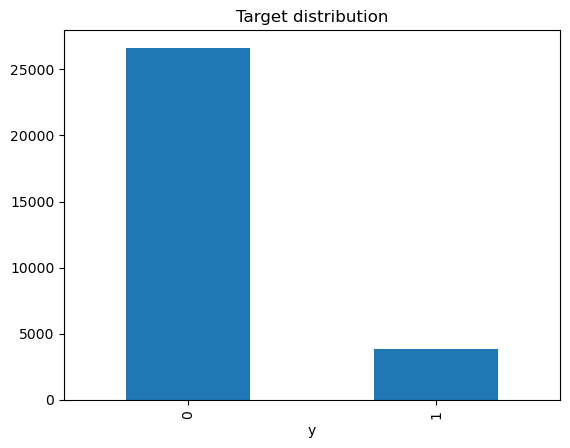

In [4]:
# looking for class imbalance

df["y"].value_counts(normalize=True)

df["y"].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.show()

## visualise the available numeric data

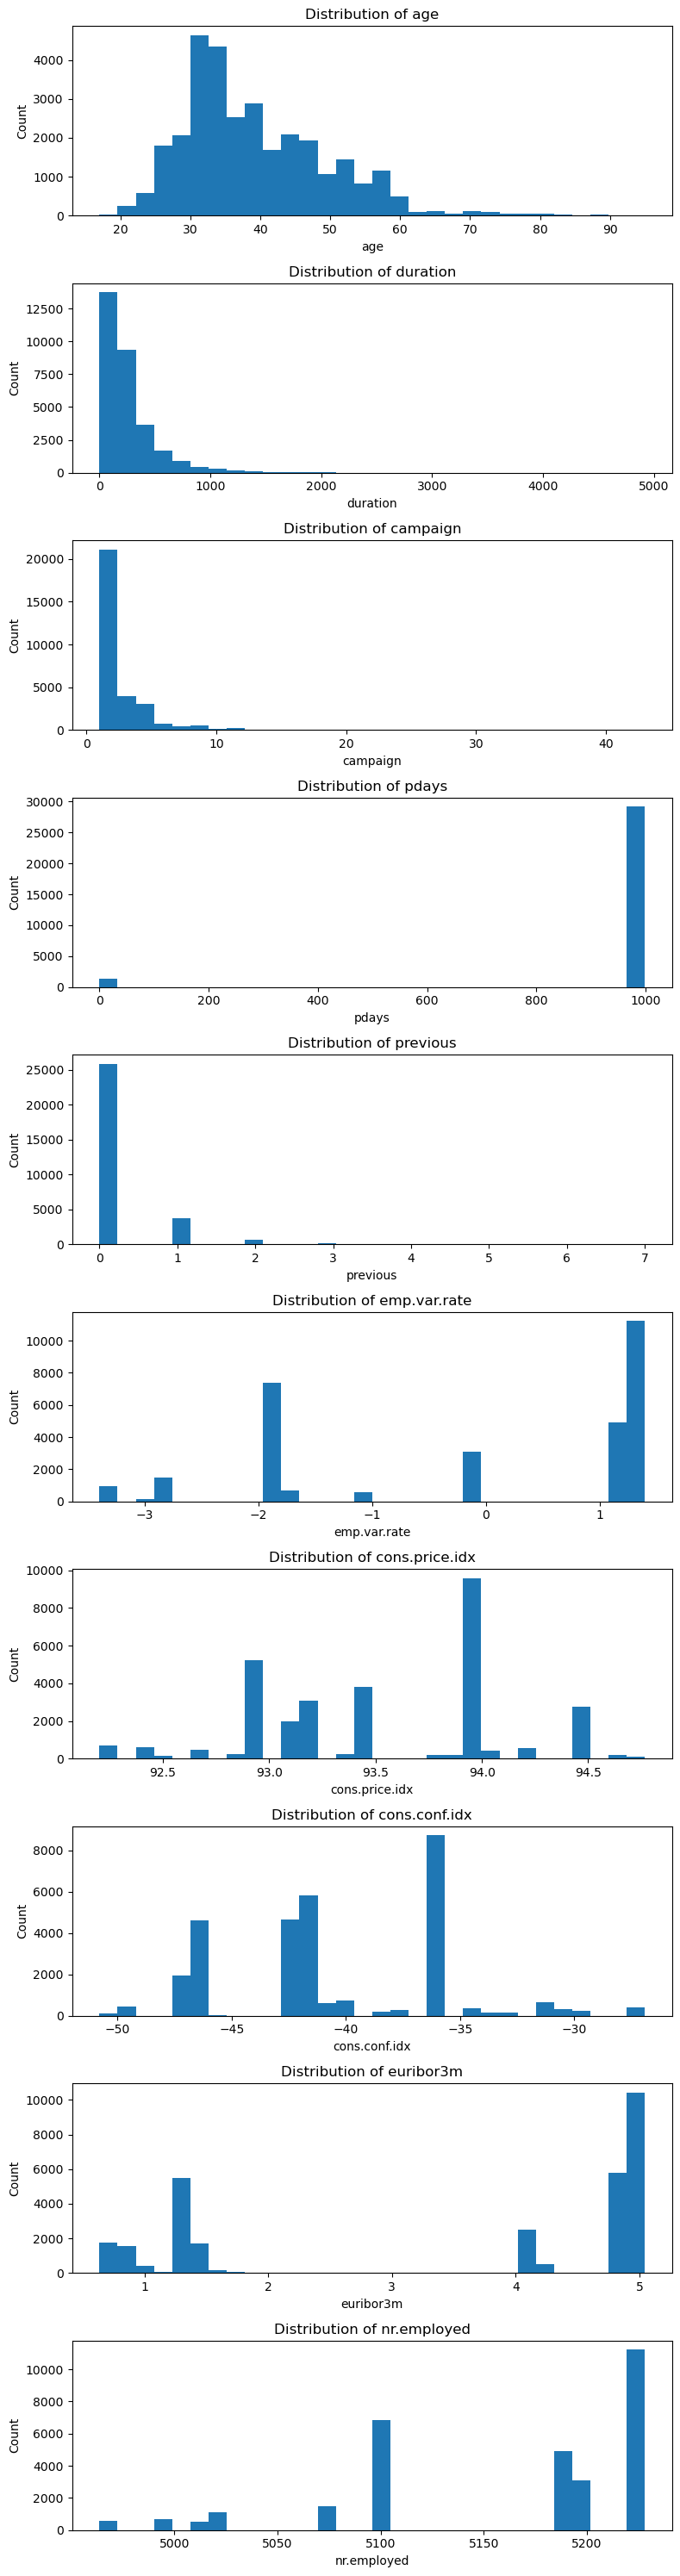

In [5]:
num_cols = df.select_dtypes(include="number").columns

num_cols = [c for c in num_cols if c != "y"] # Exclude target in visualisation (target has been made integer in data cleaning)

fig, axes = plt.subplots(
    nrows=len(num_cols),
    ncols=1,
    figsize=(8, 3 * len(num_cols))
)

for ax, col in zip(axes, num_cols):
    ax.hist(df[col], bins=30)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()



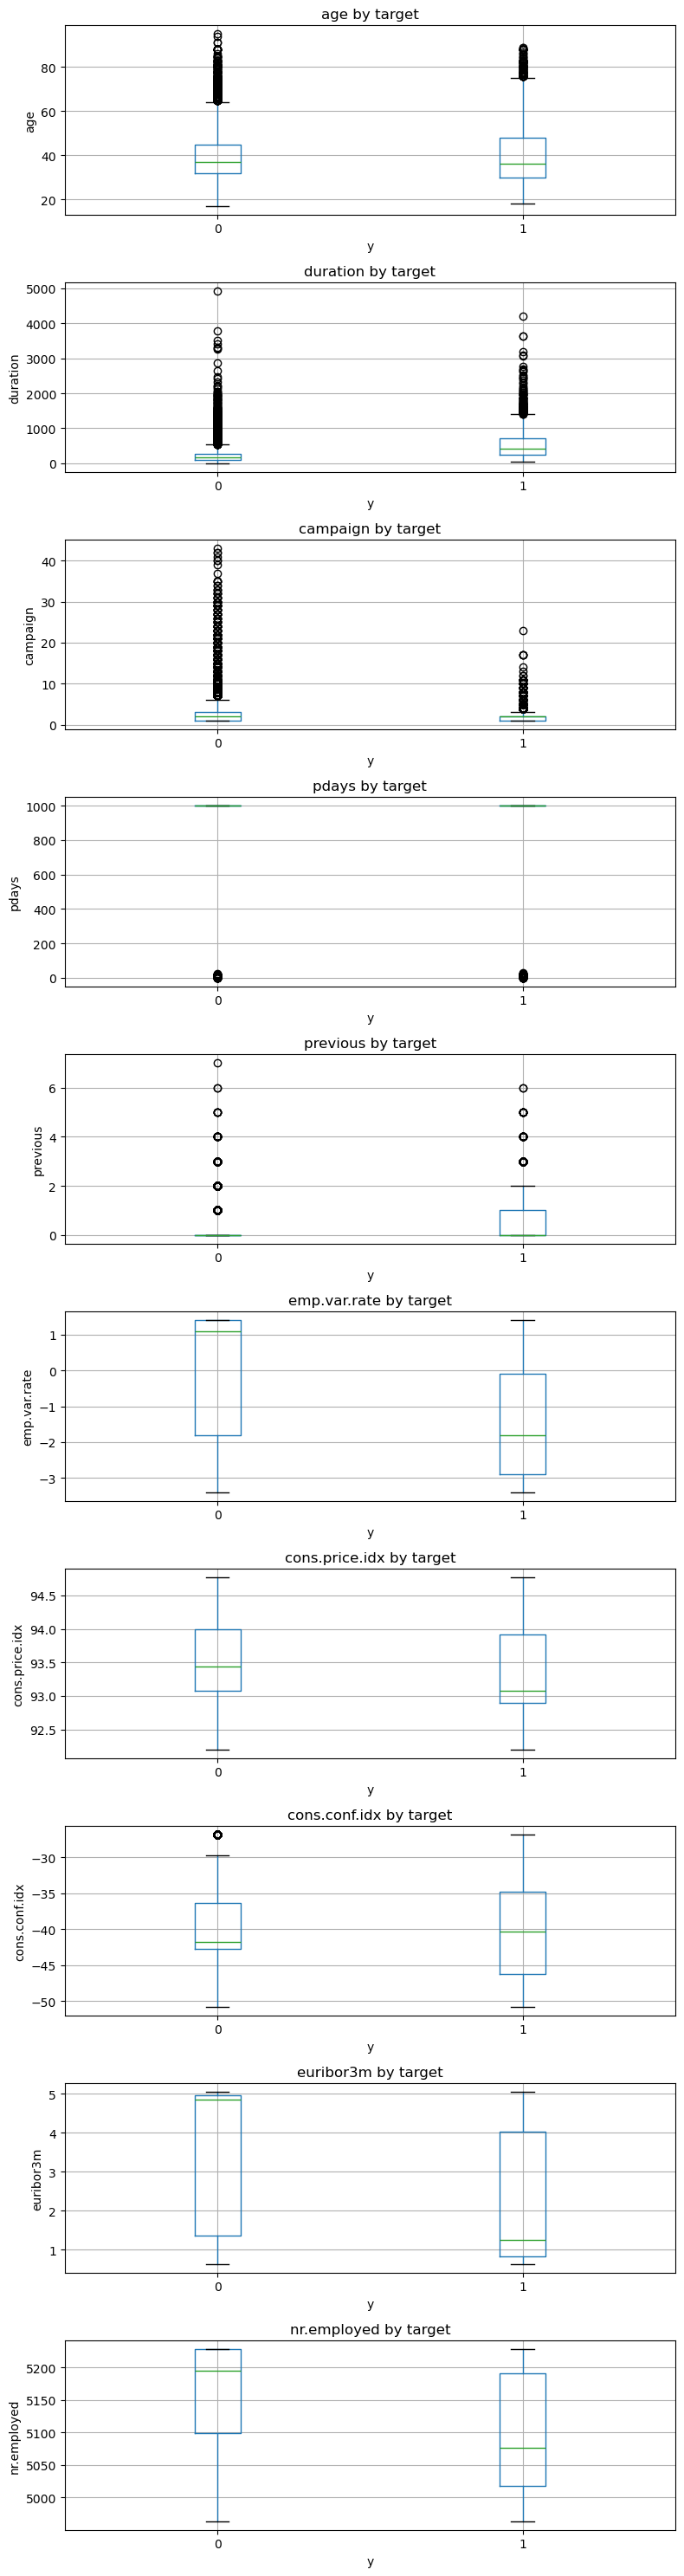

In [6]:
fig, axes = plt.subplots(
    nrows=len(num_cols),
    ncols=1,
    figsize=(8, 3 * len(num_cols))
)

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, by="y", ax=ax)
    ax.set_title(f"{col} by target")
    ax.set_xlabel("y")
    ax.set_ylabel(col)

plt.suptitle("")
plt.tight_layout()
plt.show()

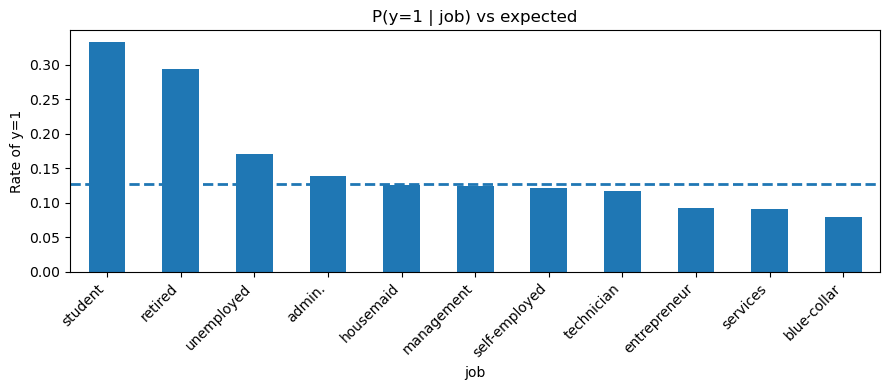

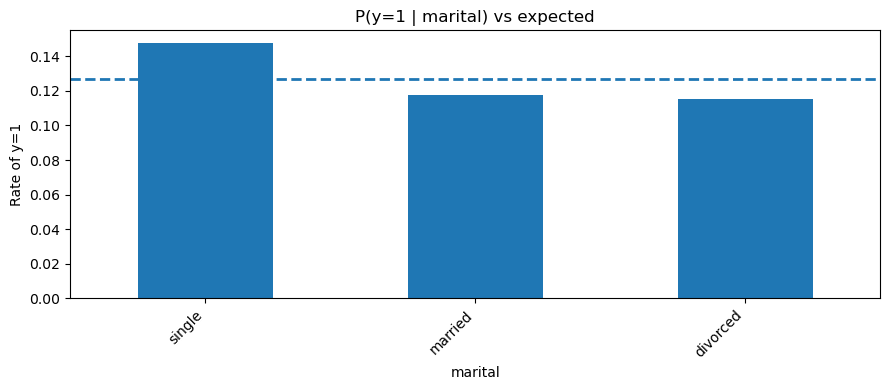

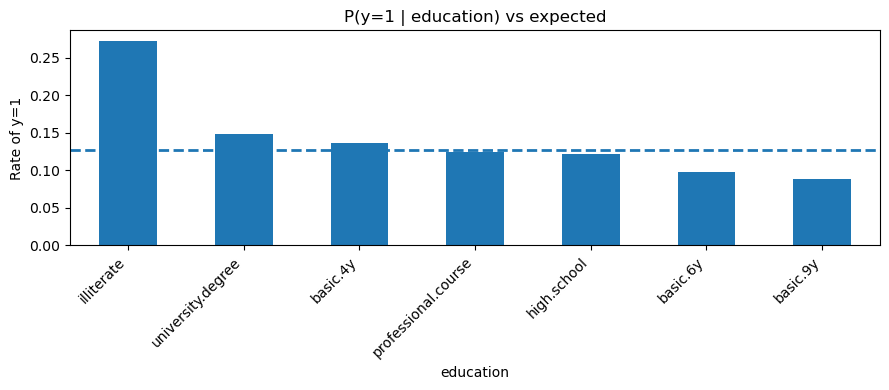

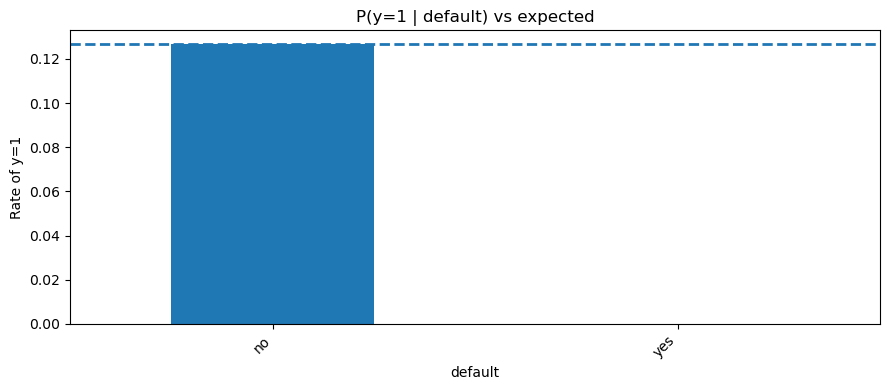

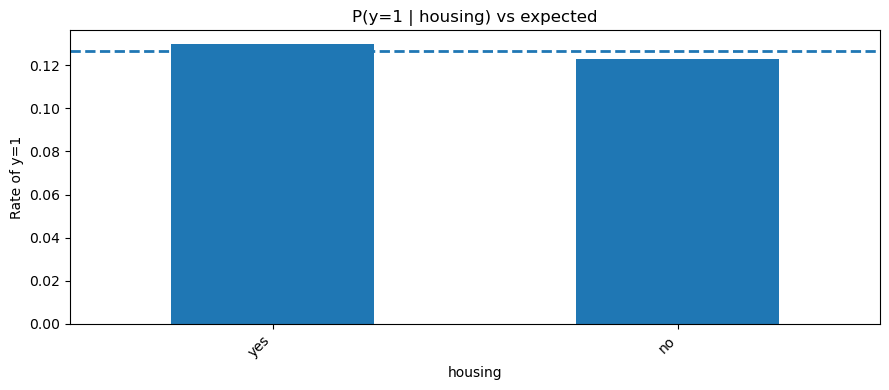

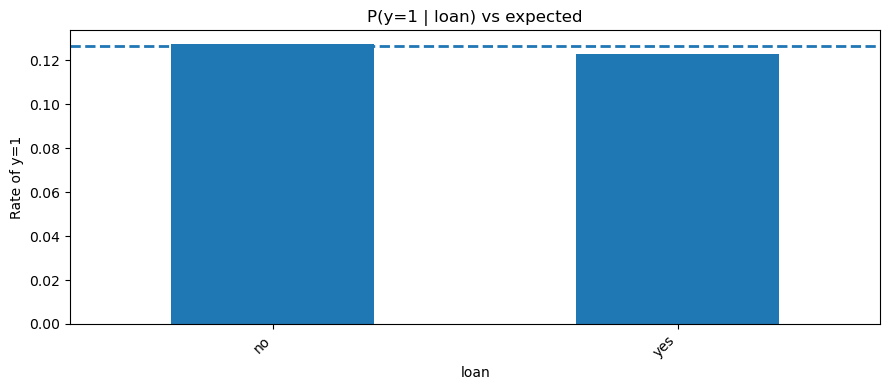

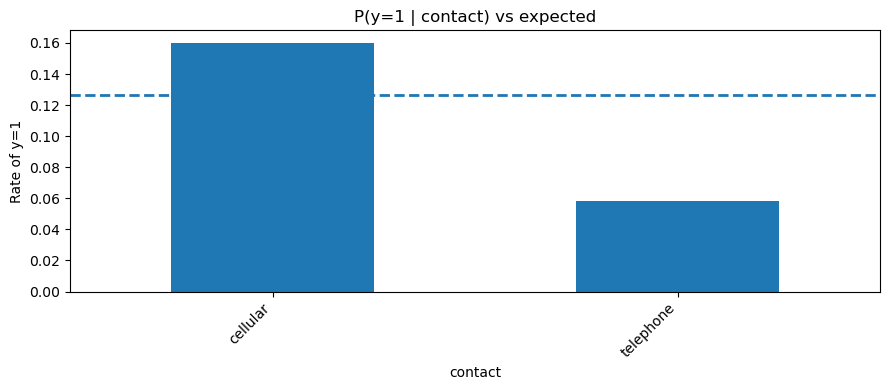

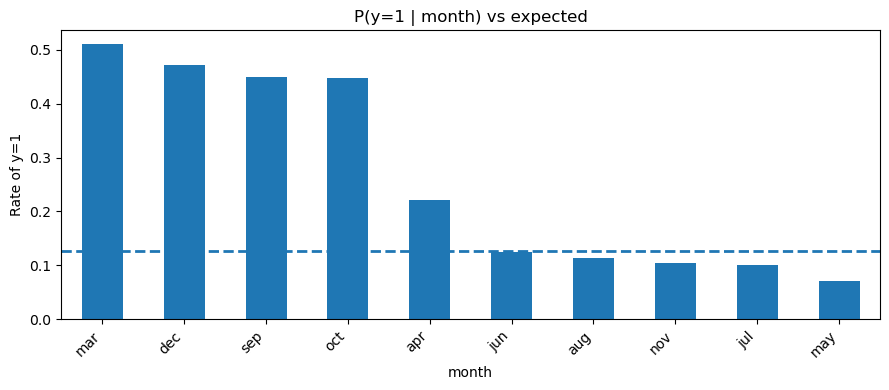

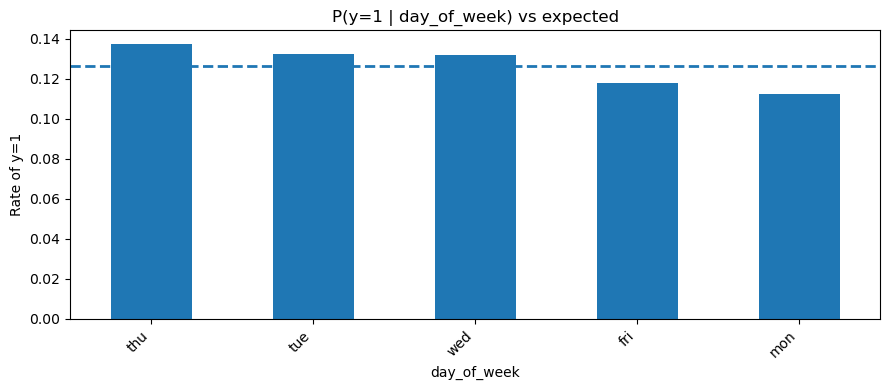

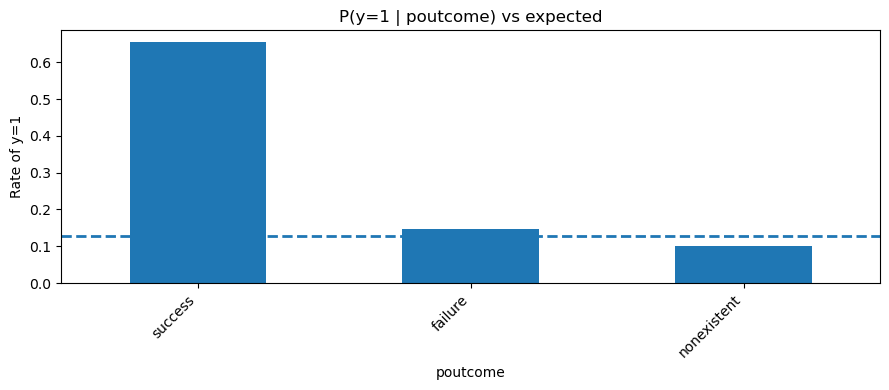

In [7]:
# Countplot for visualising categorical data by target + observed vs expected to take into consideration skewed data

def plot_cat_rate_vs_expected(df, col, target="y", top_n=15):
    data = df[[col, target]].dropna()

    # zorg dat target numeriek is
    if data[target].dtype == "object":
        data = data.copy()
        data[target] = data[target].map({"yes": 1, "no": 0})

    # observed rate per categorie
    rates = data.groupby(col)[target].mean()

    # frequenties
    freq = data[col].value_counts()

    # neem top_n meest voorkomende categorieën
    common = freq.head(min(top_n, len(freq))).index
    rates = rates.loc[common].sort_values(ascending=False)

    if rates.empty:
        print(f"Geen data om te plotten voor {col}")
        return

    expected = data[target].mean()

    ax = rates.plot(kind="bar", figsize=(9,4))
    ax.axhline(expected, linestyle="--", linewidth=2)
    ax.set_title(f"P({target}=1 | {col}) vs expected")
    ax.set_ylabel(f"Rate of {target}=1")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

cat_cols = df.select_dtypes(include="object").columns

for col in cat_cols:
    plot_cat_rate_vs_expected(df, col)


### Testing for significaant difference in data by target seperation
#### numerical: Man whitney, categorical: Chi square.
##### Chi-square tests association between categorical variables via frequency deviations, while Mann–Whitney U compares distributional shifts of numeric variables across binary outcomes.

In [8]:
# testing numerical data by target seperation for siginificant differences (Mann Whitney U, confidence 0.05, H0 == X and y are independent)

rows = []

for col in num_cols:
    g0 = df.loc[df["y"] == 0, col].dropna()
    g1 = df.loc[df["y"] == 1, col].dropna()

    # veiligheid: genoeg waarnemingen?
    if len(g0) < 20 or len(g1) < 20:
        rows.append({
            "feature": col,
            "p_value": np.nan,
            "n_y0": len(g0),
            "n_y1": len(g1),
            "note": "too few samples"
        })
        continue

    stat, p = mannwhitneyu(g0, g1, alternative="two-sided")

    rows.append({
        "feature": col,
        "p_value": p,
        "n_y0": len(g0),
        "n_y1": len(g1),
        "median_y0": g0.median(),
        "median_y1": g1.median(),
        "delta_median": g1.median() - g0.median()
    })

mw_results = (
    pd.DataFrame(rows)
      .sort_values("p_value", na_position="last")
)

mw_results

,feature,p_value,n_y0,n_y1,median_y0,median_y1,delta_median
1,duration,0.000000e+00,26620,3858,163.000,415.000,252.000
3,pdays,0.000000e+00,26620,3858,999.000,999.000,0.000
5,emp.var.rate,0.000000e+00,26620,3858,1.100,-1.800,-2.900
8,euribor3m,0.000000e+00,26620,3858,4.857,1.262,-3.595
9,nr.employed,0.000000e+00,26620,3858,5195.800,5076.200,-119.600
4,previous,6.645558e-267,26620,3858,0.000,0.000,0.000
6,cons.price.idx,1.320537e-97,26620,3858,93.444,93.075,-0.369
2,campaign,8.729411e-30,26620,3858,2.000,2.000,0.000
7,cons.conf.idx,6.800854e-16,26620,3858,-41.800,-40.400,1.400
0,age,6.823299e-01,26620,3858,37.000,36.000,-1.000


In [9]:
# testing categorical data by target seperation for siginificant differences (Chi Square, confidence 0.05, H0 == X and y are independent)

cat_cols = df.select_dtypes(include="object").columns.tolist()

rows = []
for col in cat_cols:
    tab = pd.crosstab(df[col], df["y"])

    # safety: skip als tab te groot wordt (kan RAM/CPU slopen)
    if tab.shape[0] > 200:
        rows.append({"feature": col, "p_value": np.nan, "note": f"skipped: too many levels ({tab.shape[0]})"})
        continue

    chi2, p, dof, expected = chi2_contingency(tab)
    rows.append({"feature": col, "p_value": p, "dof": dof, "levels": tab.shape[0], "note": ""})

chi_results = pd.DataFrame(rows).sort_values("p_value", na_position="last")
chi_results



,feature,p_value,dof,levels,note
7,month,0.000000e+00,9,10,
9,poutcome,0.000000e+00,2,3,
0,job,1.829045e-150,10,11,
6,contact,5.354606e-139,1,2,
2,education,1.645732e-22,6,7,
1,marital,1.366346e-12,2,3,
8,day_of_week,3.842871e-05,4,5,
4,housing,7.869988e-02,1,2,
5,loan,3.920664e-01,1,2,
3,default,1.000000e+00,1,2,


## Conclusions after data analysis

#### duration will be removed from dataset due to it being determined "post event", therefore creating a significant risk of data leakage
#### poutcome will be treated with caution because of it being a strong indicator, therefore leaving the model at risk of heavily weighing historical data in fitting

### significance test on numerical
#### very strong (p == 0) (rounded)
- duration
- pdays
- emp.var.rate
- euribor3m
- nr.employed

#### strong (0 < p <= 0.05)
- previous
- cons.price.idx
- campaign
- cons.conf.idx

#### weak (p > 0.05)
- age

### significance test on categorical
#### very strong (p == 0) (rounded)
- month
- poutcome
- job

#### strong (0 < p <= 0.05)
- contact
- education
- marital
- day_of_week

#### weak (p > 0.05)
- housing
- loan
- default


In [10]:
df.columns.tolist()


['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']